<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation-with-Deep-Learning/blob/master/src/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select your Dataset

In [0]:
# Insert an integer value for the DATASET_CHOICE variable below
# 0 = Symbol Set
# 1 = cifar10 (You can also choose a class with the CIFAR10_CLASS variable)
# 2 = Celeb faces
# 3 = ImageNette (You must choose a category with the IMAGENETTE_CATEGORY variable)
DATASET_CHOICE = 1
# If you wish to use a specific cifar10 class, specify one here, otherwise assign the variable to None
CIFAR10_CLASS = 6
# If using imagenette specify the image category to train on here
# Choose one of the following: "dog", "paraglider", "golfball", "church", "fish"
IMAGENETTE_CATEGORY = "dog"

# Define Global Parameters


In [0]:
BATCH_SIZE = 100
LATENT_DIM = 128
EPOCHS = 100

# Library Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import tensorflow as tf

from scipy.stats import norm
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, Lambda, Reshape, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
from skimage import io
from skimage.transform import resize

# Dataset Setup

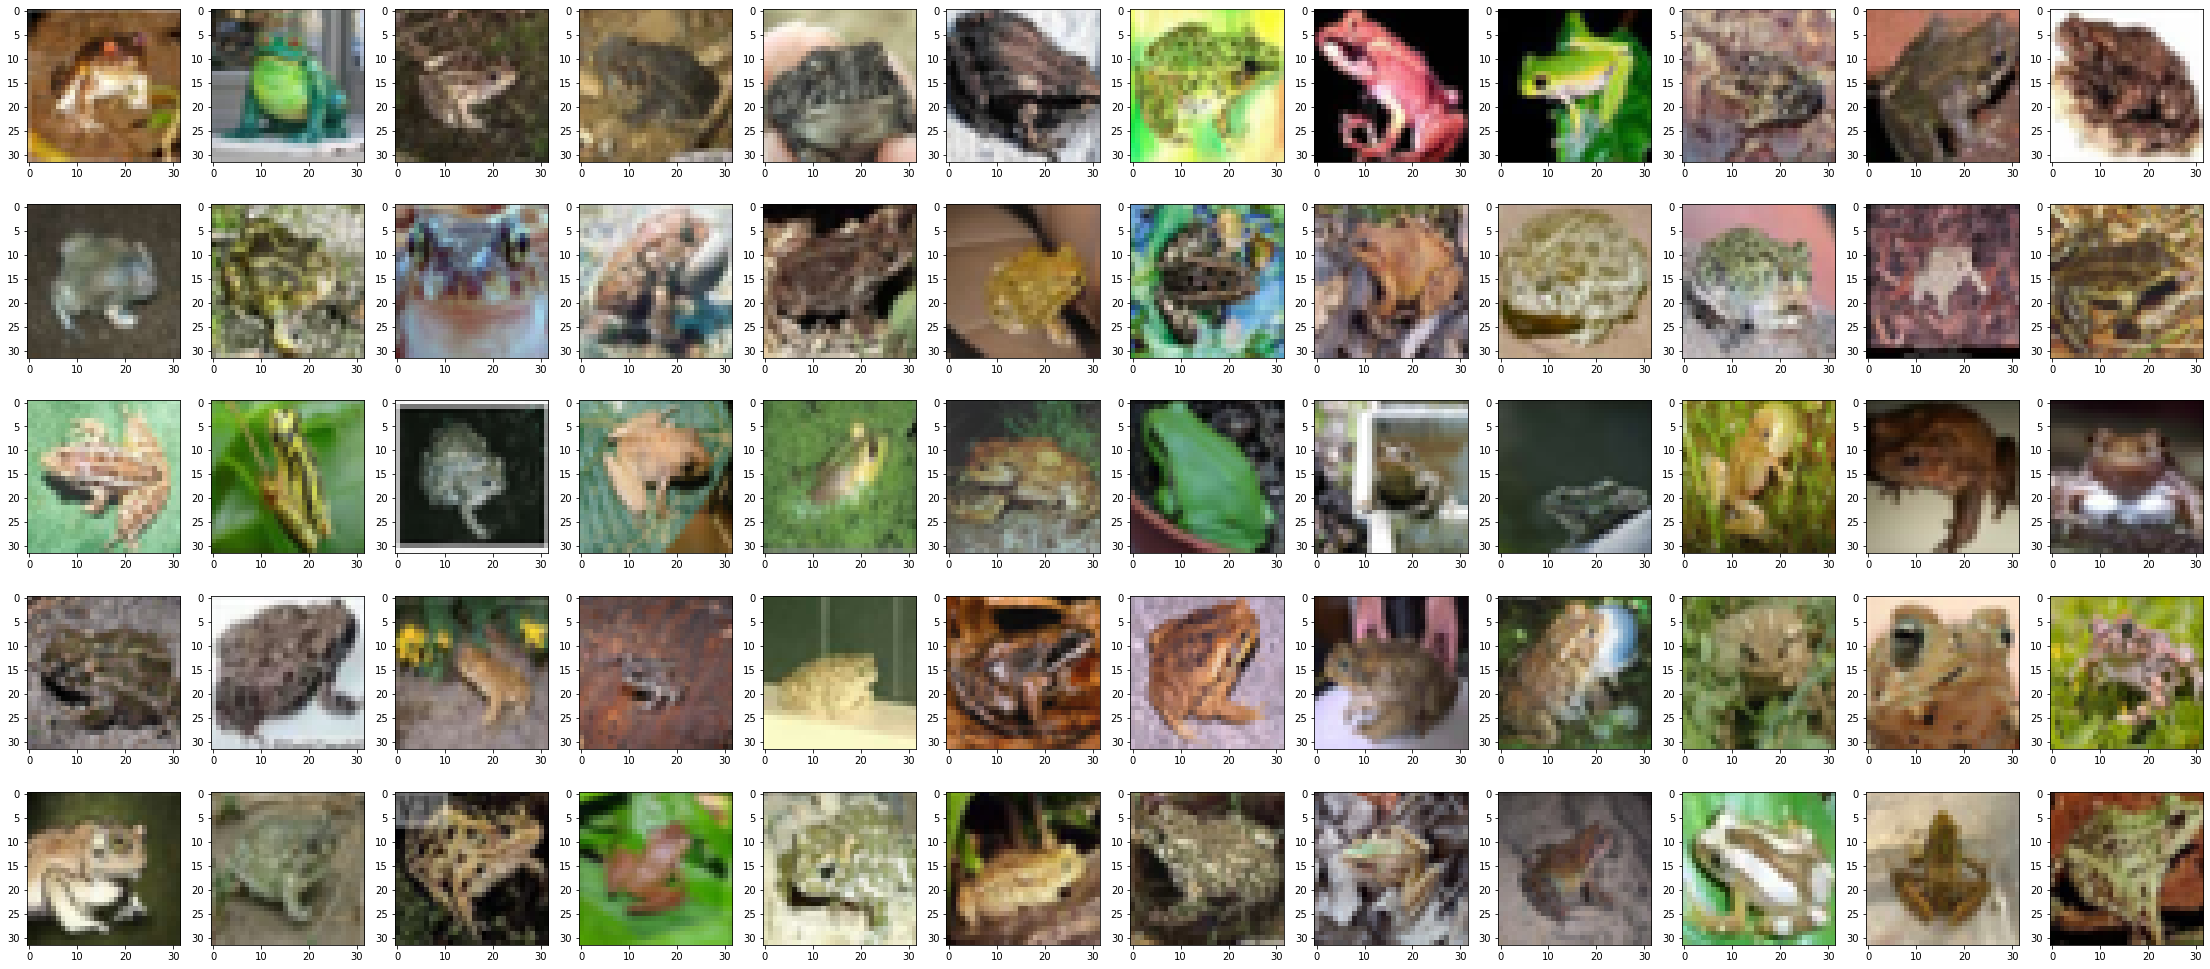

In [0]:
# TODO: DECIDE ON GITHUB OR DRIVE FOR HOSTING
# TODO: ADD CODE TO SAVE TRAINED MODEL
if(DATASET_CHOICE == 0):
  from google.colab import drive, files
  drive.mount("/content/gdrive", force_remount=True)
  !unzip -uq "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/SymbolSet.zip" -d "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/" 
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/SymbolSet/Symbol Set"

  images = []
  for image in io.imread_collection(base_dir + "/*.jpg"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images[1:-1:2])
  test_images = np.array(images[0:-2:2])

  output_count = 9
  index_offset = 0

  print(train_images.shape)

  indexes = np.array([np.arange(5,8)])
  indexes = np.append(indexes, np.arange(8,11))
  indexes = np.append(indexes, np.arange(20,23))
  output_images = np.array(images)[indexes]
  fig = plt.figure(figsize=(39, 21))
  for i in range(output_count):
    ax = fig.add_subplot(1,output_count,i+1)
    plt.imshow(output_images[i])

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = (train_images[:,:,:,0] + train_images[:,:,:,1] + train_images[:,:,:,2]) / 3
  train_y = tf.expand_dims(train_y[:,:,:], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = (test_images[:,:,:,0] + test_images[:,:,:,1] + test_images[:,:,:,2]) / 3
  test_y = tf.expand_dims(test_y[:,:,:], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 1):
  (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
  train_images = train_images / 255.0
  test_images = test_images / 255.0

  if(CIFAR10_CLASS is not None):
    class_train_indices = np.argwhere(train_labels == CIFAR10_CLASS)
    train_images = train_images[class_train_indices[:,0]]
    train_labels = train_labels[class_train_indices[:,0]]
    class_test_indices = np.argwhere(test_labels == CIFAR10_CLASS)
    test_images = test_images[class_test_indices[:,0]]
    test_labels = test_labels[class_test_indices[:,0]]

  image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      if(CIFAR10_CLASS is None):
        plt.title(image_labels[int(train_labels[count])])
      plt.imshow(train_images[count])
      count += 1

  output_count = 12
  index_offset = 20

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 2):
  !git clone https://github.com/2014mchidamb/DeepColorization/

  images = train_images = test_images = []
  for image in io.imread_collection('DeepColorization/face_images/*.jpg'): 
    images.append(resize(image, (128, 128)))
    
  train_images = np.array(images)[0:-1:2,:,:,:]
  test_images = np.array(images)[1::2,:,:,:]

  index_offset = 20
  output_count = 12
  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      plt.imshow(train_images[30+count])
      count += 1

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

elif(DATASET_CHOICE == 3):
  from google.colab import drive, files
  drive.mount("/content/gdrive", force_remount=True)
  base_dir = "/content/gdrive/My Drive/Dissertation/Data/imagenette2-160/"

  categories = {"dog":"n02102040", "paraglider":"n03888257", "golfball":"n03445777", "church":"n03028079", "fish":"n01440764"}
  print("Loading and resizing training and testing images, this may take a few minutes.")
  images = []
  for image in io.imread_collection(base_dir + "train/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  train_images = np.array(images)
  images = []
  for image in io.imread_collection(base_dir + "val/" + categories[IMAGENETTE_CATEGORY] + "/*.JPEG"): 
    image = np.array(resize(image, (128, 128)))
    if(image.shape == (128, 128, 3)):
      images.append(image)
  test_images = np.array(images)

  fig = plt.figure(figsize=(39, 21))
  count = 0
  for i in range(5):
    for j in range(12):
      ax = fig.add_subplot(6,12,count+1)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)  
      plt.imshow(train_images[30+count])
      count += 1

  index_offset = 0
  output_count = 12

  train_yuv  = tf.image.rgb_to_yuv(train_images)
  train_y = tf.expand_dims(train_yuv[:,:,:,0], 3)
  train_uv = train_yuv[:,:,:,1:]

  test_yuv = tf.image.rgb_to_yuv(test_images)
  test_y = tf.expand_dims(test_yuv[:,:,:,0], 3)
  test_uv = test_yuv[:,:,:,1:]

In [0]:
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder_deconv.py
# https://xiangyutang2.github.io/auto-colorization-autoencoders/

class VAE():
  def __init__(self):
      optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

      
      self.training_encoder = self.build_training_encoder()
      self.conditional_encoder = self.build_training_encoder()
      self.decoder = self.build_decoder()

      # The generator takes noise as input and generated imgs
      y_image = layers.Input(shape=(32, 32, 1))
      uv_image = self.generator(y_image)

      # For the combined model we will only train the generator
      self.discriminator.trainable = False

      # The valid takes generated images as input and determines validity
      validity = self.discriminator(uv_image)

      # The combined model  (stacked generator and discriminator) takes
      # noise as input => generates images => determines validity
      self.combined = models.Model(y_image, validity)
      self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

      self.gen_loss_history = []
      self.disc_loss_history = []
      self.disc_acc_history = []

# Sampling with the reparametrisation trick
def sample(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

def create_training_encoder(yuv_in, latent_dim):

yuv_in = Input(shape=(train_yuv.shape[1], train_yuv.shape[2], train_yuv.shape[3]))
y_in = Input(shape=(train_y.shape[1], train_y.shape[2], train_y.shape[3]))

# Define Training Encoder q(z|yuv)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(yuv_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
shape = K.int_shape(layer) # Shape before flattening

# Latent space for encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_training = Dense(LATENT_DIM)(layer)
z_log_var_training = Dense(LATENT_DIM)(layer)
z_training = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_training, z_log_var_training]) # Data passable to the decoder

# Instantiate encoder 
encoder_training = Model(yuv_in, z_training, name='training_encoder')
encoder_training.summary()

Model: "training_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 16, 16, 8)    224         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 8, 8, 16)     1168        conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_9[0][0]                   
___________________________________________________________________________________

In [0]:
# Define Conditional Encoder p(z|y)
layer = Conv2D(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(y_in)
layer = Conv2D(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2D(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)

# Latent space for conditional encoder
layer = Flatten()(layer)
layer = Dense(512, activation='relu')(layer)
z_mean_conditional = Dense(LATENT_DIM)(layer)
z_log_var_conditional = Dense(LATENT_DIM)(layer)
z_conditional = Lambda(sample, output_shape=(LATENT_DIM,))([z_mean_conditional, z_log_var_conditional]) # Data passable to the decoder

# Instantiate conditional encoder
encoder_conditional = Model(y_in, z_conditional, name='conditional_encoder')
encoder_conditional.summary()

Model: "conditional_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 8)    80          input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 8, 8, 16)     1168        conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 4, 4, 64)     9280        conv2d_13[0][0]                  
________________________________________________________________________________

In [0]:
# Define Decoder p(yuv|z,y)
latent_inputs = Input(shape=(LATENT_DIM,))
layer = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
layer = Reshape((shape[1], shape[2], shape[3]))(layer)
layer = Conv2DTranspose(filters=128, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=64, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=16, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', strides=2, padding='same')(layer)
uv_out = Conv2DTranspose(filters=2, kernel_size=3, activation='tanh', padding='same')(layer)
concat_outputs = concatenate([uv_out, y_in], 3)
layer = Conv2DTranspose(filters=8, kernel_size=3, activation='relu', padding='same')(concat_outputs)
yuv_out = Conv2DTranspose(filters=3, kernel_size=3, activation='tanh', padding='same')(layer)

# Instantiate Decoder
decoder = Model([latent_inputs, y_in], yuv_out, name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          66048       input_6[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 2, 2, 128)    0           dense_13[0][0]                   
__________________________________________________________________________________________________
conv2d_transpose_7 (Conv2DTrans (None, 4, 4, 128)    147584      reshape_1[0][0]                  
____________________________________________________________________________________________

In [0]:
# TODO: CLEAN UP THIS LOSS FUNCTION AND FIND A SUITABLE SIZE FOR RECONSTRUCTION

# Instantiate VAE
training_yuv_out = decoder([z_training, y_in])
training_vae = Model([yuv_in, y_in], training_yuv_out, name='training_vae')
# training_vae.summary()

# Reconstruction loss
reconstruction_loss = K.sum(mse(yuv_in, training_yuv_out))
reconstruction_loss *= (train_yuv.shape[1] * train_yuv.shape[2]) # Everything turns out orange if you don't upscale the reconstruction

# KL(q(z|uv,y)||p(z|y))
# log(sig2/sig1) + (sig1^2 + (mu1-mu2)^2)/2sig2^2 - 1/2
SMALL_CONSTANT = 1e-6
sig2 = K.log(K.exp(z_log_var_conditional)+SMALL_CONSTANT)
sig1 = K.log(K.exp(z_log_var_training)+SMALL_CONSTANT)
log_sig2 = K.log(K.sqrt(K.exp(sig2)))
log_sig1 = K.log(K.sqrt(K.exp(sig1))) 
kl_loss_a = log_sig2 - log_sig1 + ((K.exp(sig1) + K.square(z_mean_training-z_mean_conditional))/(2*K.exp(sig2))) - 0.5
kl_loss_b = K.sum(kl_loss_a, 1)
kl_loss = K.mean(kl_loss_b)

training_loss = K.mean(reconstruction_loss + kl_loss)
training_vae.add_loss(training_loss)
training_vae.compile(optimizer='adam')

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_5:0


In [0]:
# Instantiate and train VAE

history = training_vae.fit([train_yuv, train_y], shuffle=False, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=([test_yuv, test_y], None))

Train on 5000 samples, validate on 1000 samples
Epoch 1/100
5000/5000 [==============================] - 3s 677us/sample - loss: 155693.7453 - val_loss: 46158.2629
Epoch 2/100
5000/5000 [==============================] - 1s 271us/sample - loss: 36888.5848 - val_loss: 41565.2121
Epoch 3/100
5000/5000 [==============================] - 1s 277us/sample - loss: 32766.4225 - val_loss: 40573.7684
Epoch 4/100
5000/5000 [==============================] - 1s 270us/sample - loss: 30976.2591 - val_loss: 40182.3414
Epoch 5/100
5000/5000 [==============================] - 1s 271us/sample - loss: 29872.3711 - val_loss: 40140.0613
Epoch 6/100
5000/5000 [==============================] - 1s 273us/sample - loss: 29085.3809 - val_loss: 40240.4797
Epoch 7/100
5000/5000 [==============================] - 1s 277us/sample - loss: 28457.5264 - val_loss: 40284.6590
Epoch 8/100
5000/5000 [==============================] - 1s 276us/sample - loss: 28066.3709 - val_loss: 40302.8996
Epoch 9/100
5000/5000 [========

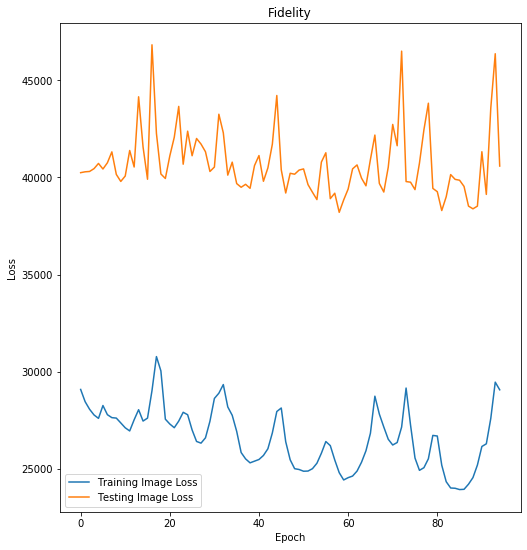

In [0]:
fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(history.history["loss"][5:], label="Training Image Loss")
plt.plot(history.history["val_loss"][5:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


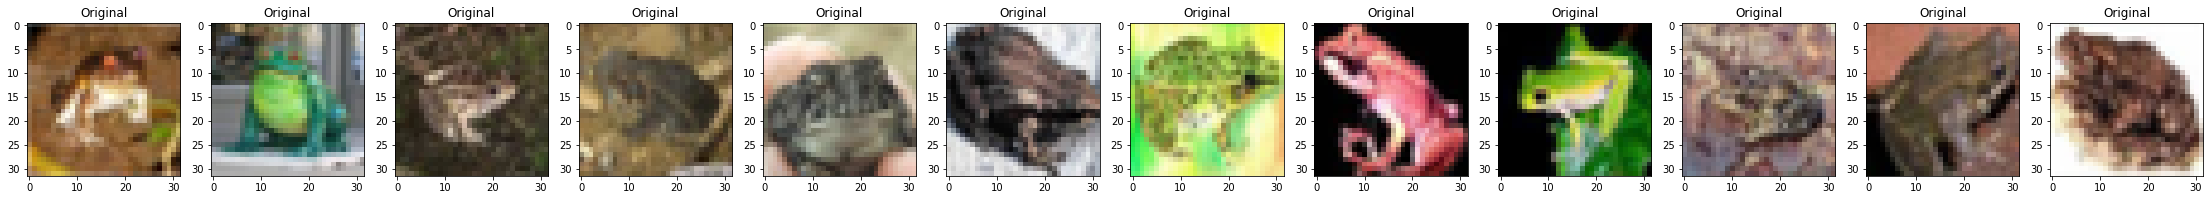

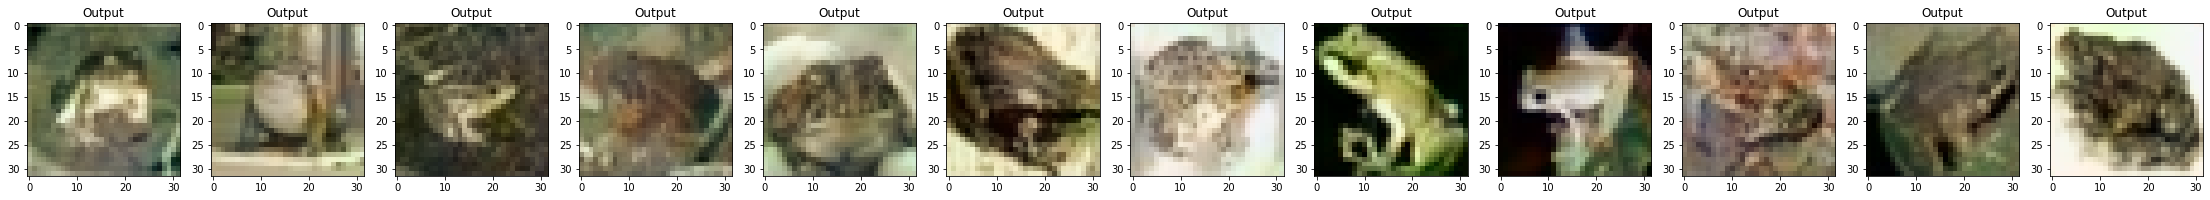

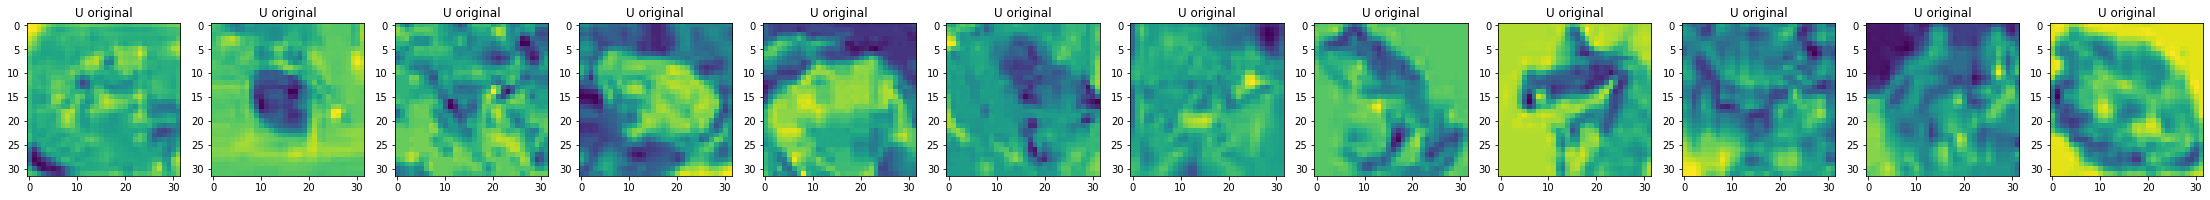

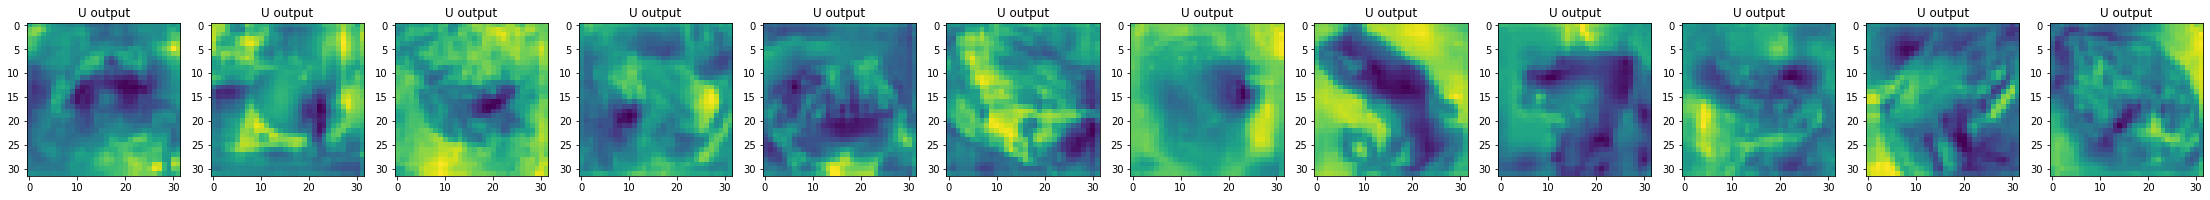

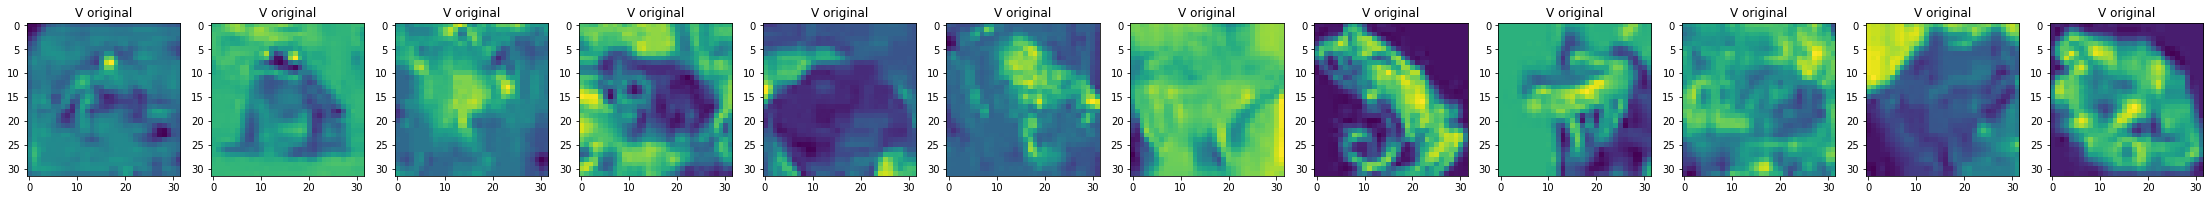

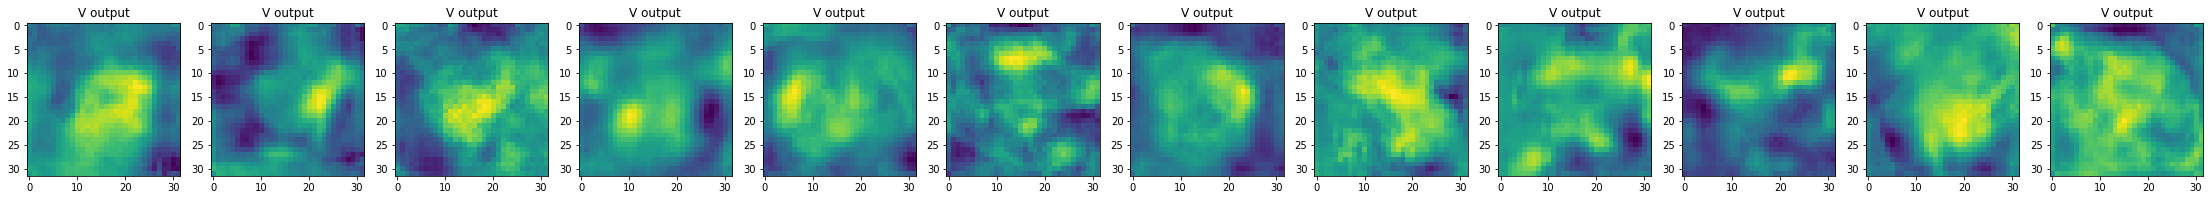

In [0]:
umap = LinearSegmentedColormap.from_list('mycmap', ['blue', 'green'])
vmap = LinearSegmentedColormap.from_list('mycmap', ['red', 'yellow'])

sample_z = encoder_conditional.predict(train_y)
result = decoder.predict([sample_z, train_y])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[i+index_offset])

# fig = plt.figure(figsize=(39, 39))
# for i in range(output_count):
#   fig.add_subplot(1,output_count,i+1)
#   plt.title("Input")
#   plt.imshow(tf.image.grayscale_to_rgb(train_y[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


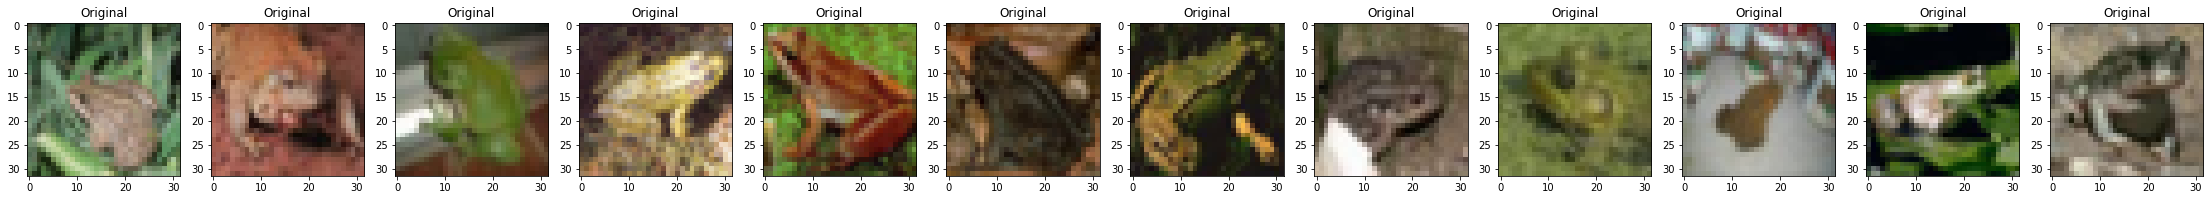

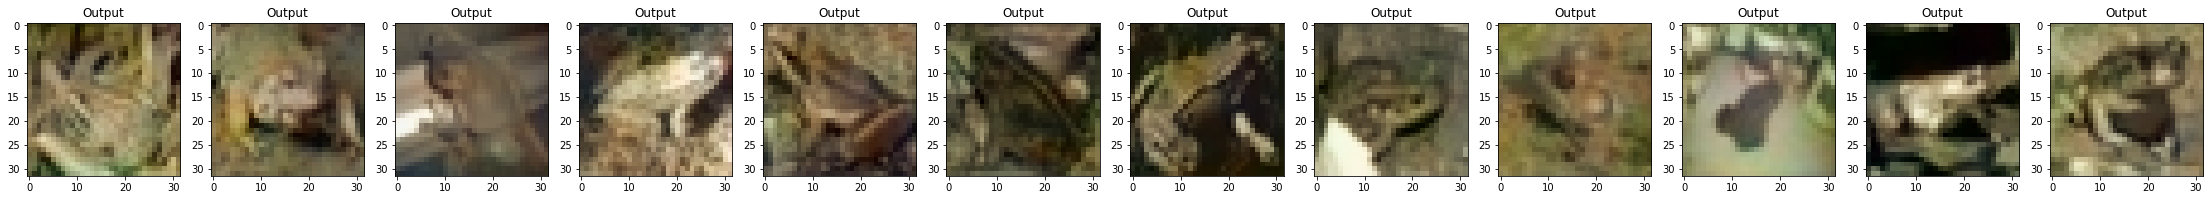

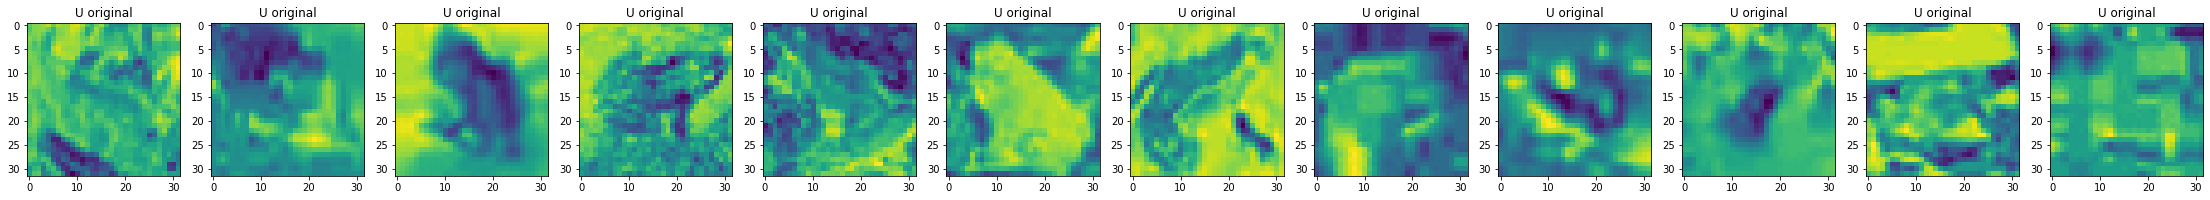

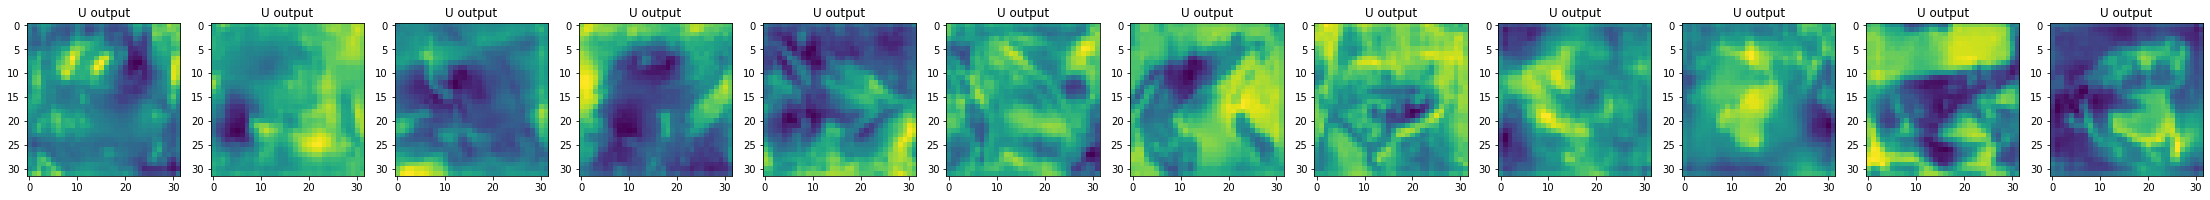

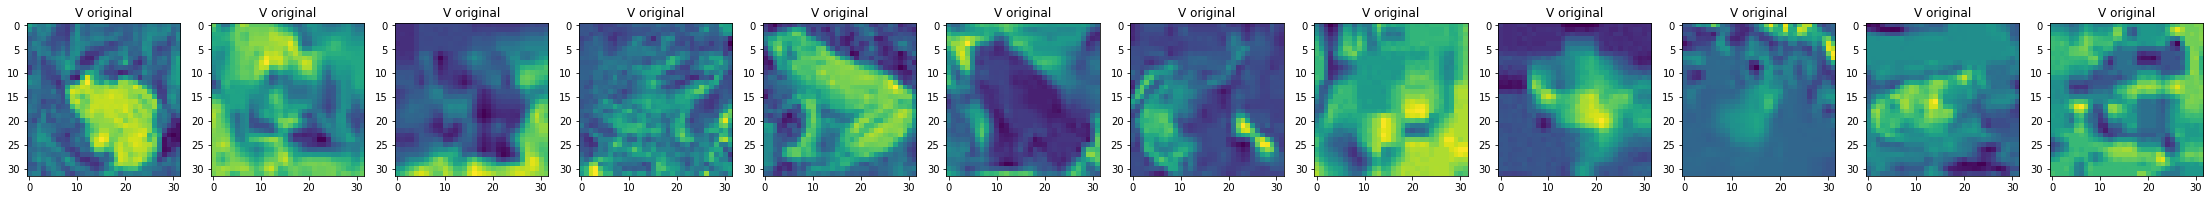

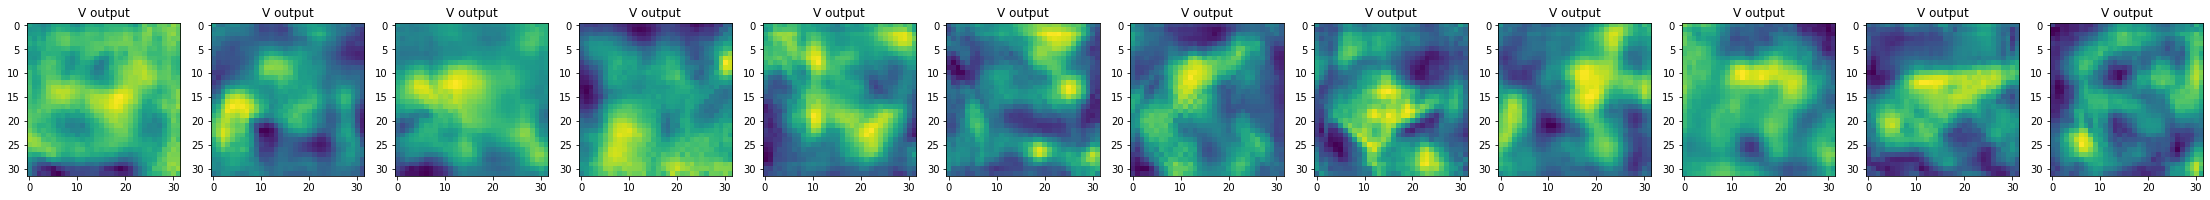

In [0]:
sample_z = encoder_conditional.predict(test_y)
result = decoder.predict([sample_z, test_y])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[i+index_offset])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[i+index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuv[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[i+index_offset,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuv[i+index_offset,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[i+index_offset,:,:,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

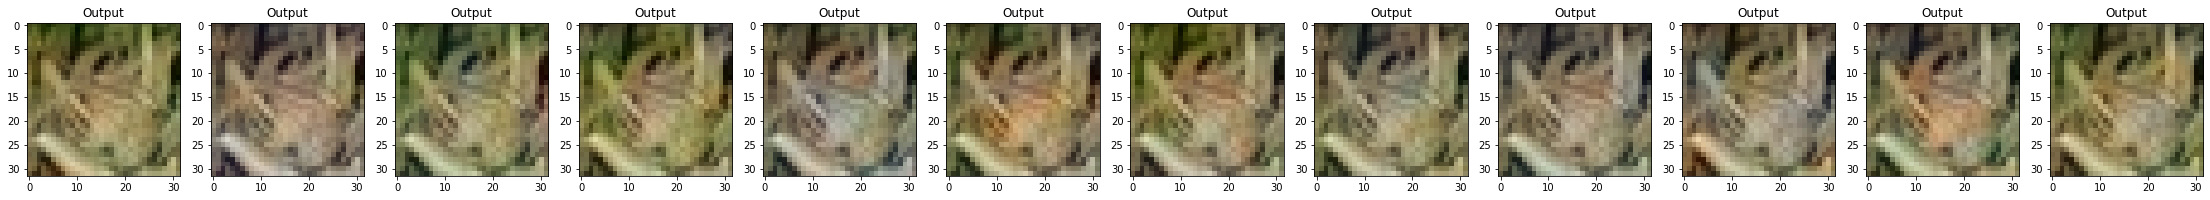

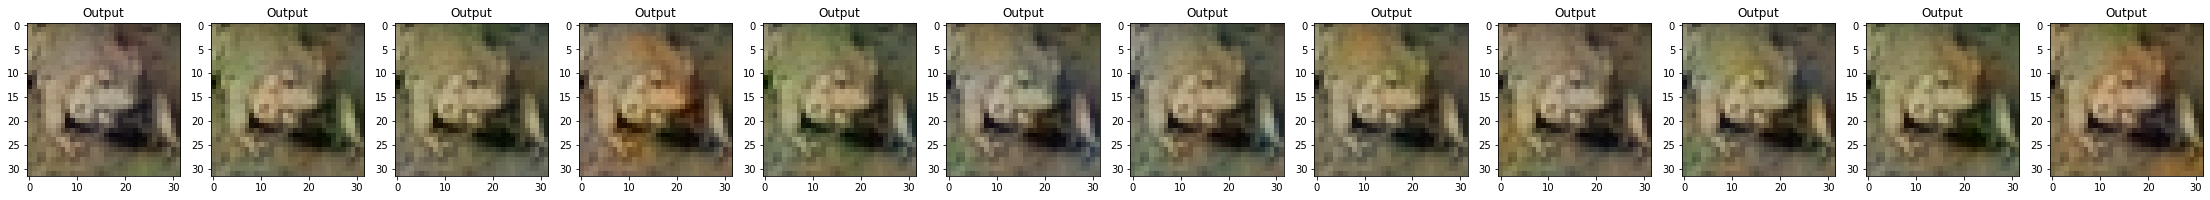

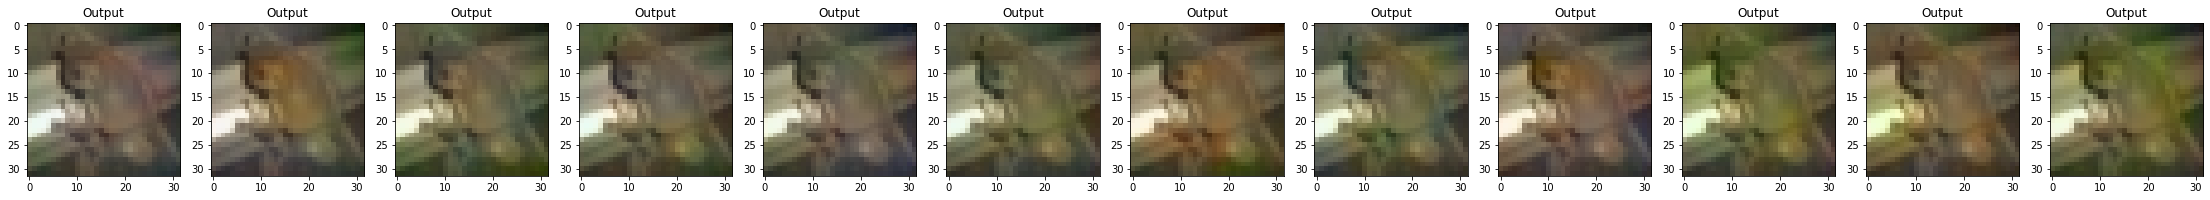

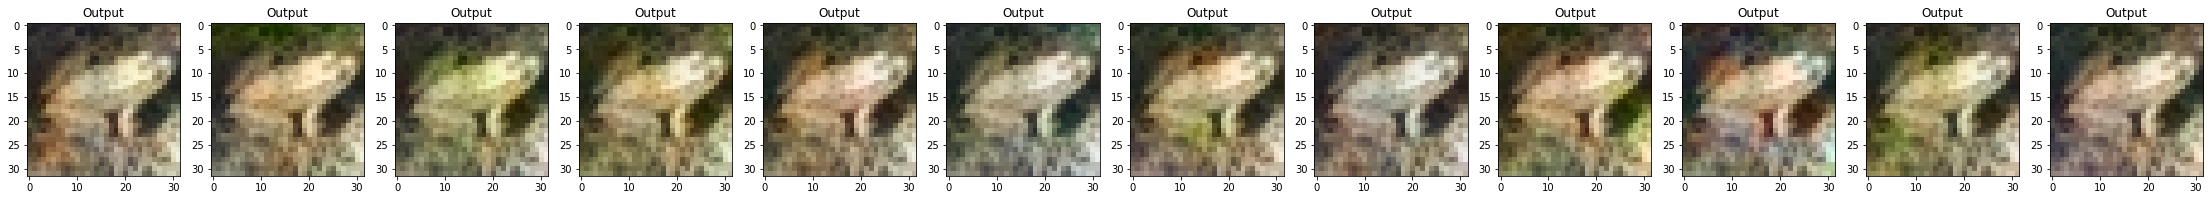

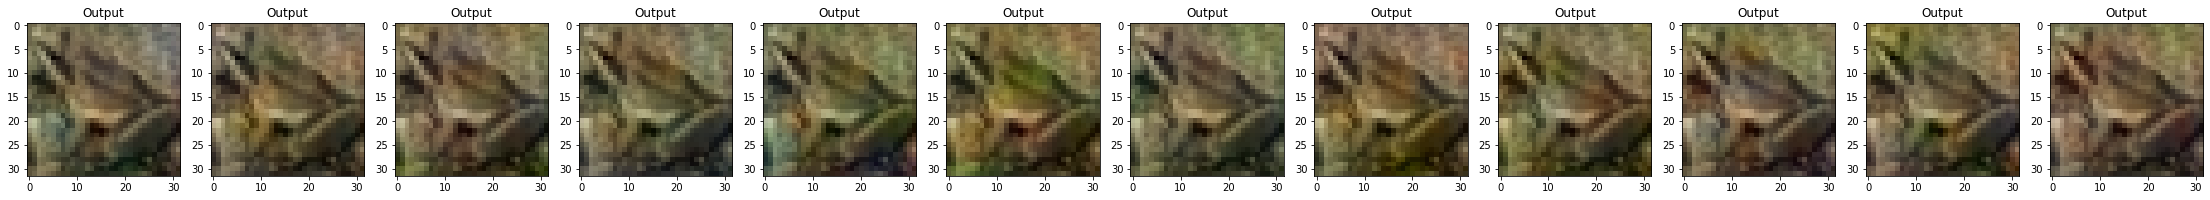

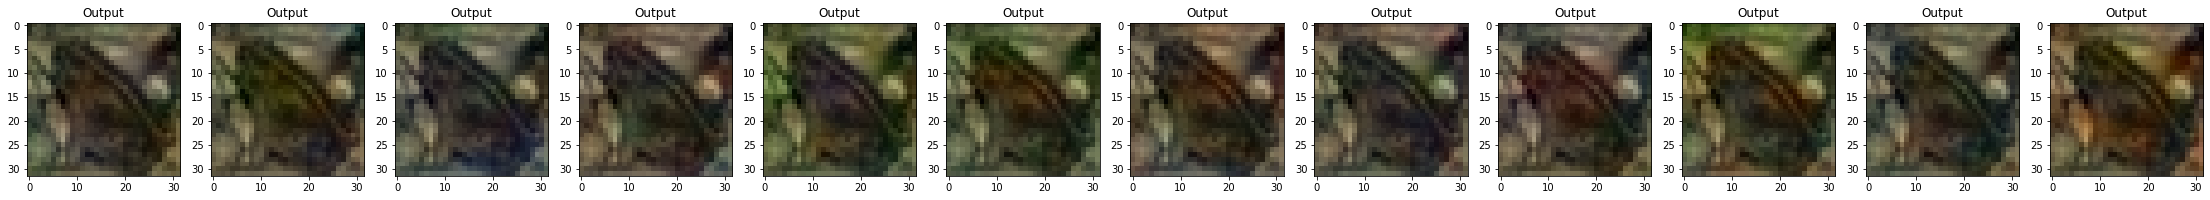

In [0]:
# TODO: GET RID OF THESE INPUT CLIPPING MESSAGE

output_count = 12
index_offset = 0

diverse_colourisations = []
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  diverse_colourisations.append(result)

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+1]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+2]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+3]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+4]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  sample_z = encoder_conditional.predict(test_y)
  result = decoder.predict([sample_z, test_y])
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(diverse_colourisations[i][index_offset+5]))